In [1]:
push!(LOAD_PATH, "../src")

using MyProject.StochasticLanczos
using MyProject.Estimators
using MyProject.Utils
using LinearAlgebra
using Plots

## Intro
Since, in practice, reorthogonalization _must_ be used to maintain stability of the Lanczos iteration, really it's not fair to compare convergence with different block sizes given the same number of Lanczos iterates, because the nonblocked algorithms will generally have smaller comptuational complexity (due to the reorthogonalization cost scaling with $b^2$). A better comparison can be obtained by comparing convergence of different block sizes with (roughly) the same number of flops. We use the following estimator of the total number of flops per block Lanczos iteration (performed once for each block trace estimation)
$$
\tilde{F} = 2k \text{nnz}(\mathbf{A})b + f\frac{3}{2}b^2nk(k-1) + 2kbn
$$
where $k$ is the number of Lanczos iterations, $b$ is the block size, $n$ is the dimension of $\mathbf{A}$ (i.e. $\mathbf{A}\in \mathbb{R}^{n\times n}$), and $f$ is the reorthogonalization fraction. For simplicity, and to ensure convergence, we take $f=1$. The first term is the cost of the single block matvec with $\mathbf{A}$ each iteration, the second term is the reorthogonalization cost, and the last term is a linear (in iteration number and block size) cost for normalization at each step. Now, since we do this for each of the samples, we need to multiply by
$$
\hat{F} = \frac{s}{b}\tilde{F}
$$

## Block-Dependence of Convergence for Equal Number of Flops
We use a given test case from SuiteSparse to benchmark the block dependence of the convergence with equal flop count as described above.

In [2]:
include("test_cases/bcsstk09_case.jl")

1.831131780992277e10

In [3]:
s = 60
nnzA = nnz(A)
reorth_frac = 1.0

function F_hat(k, b)
    return ( s ÷ b ) * ( 2*k*nnzA*b + reorth_frac*3/2*b^2*n*k*(k-1) + 2*k*b*n )
end

F_hat (generic function with 1 method)

In [4]:
b = 2
k_converged = 40
Ω_provided = rand([-1,1], n, s)
converged_estimate = hutchinson_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided, 
    reorthogonalization_fraction=reorth_frac)

1.836915693691606e10

In [ ]:
ks = collect(1:1:15)
bs = divisors(s)[1:end-1]
partial_hutchinson_estimator = (b, k) -> 
                hutchinson_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided, reorthogonalization_fraction=reorth_frac)
block_estimates = compute_block_estimates(ks, bs, partial_hutchinson_estimator);

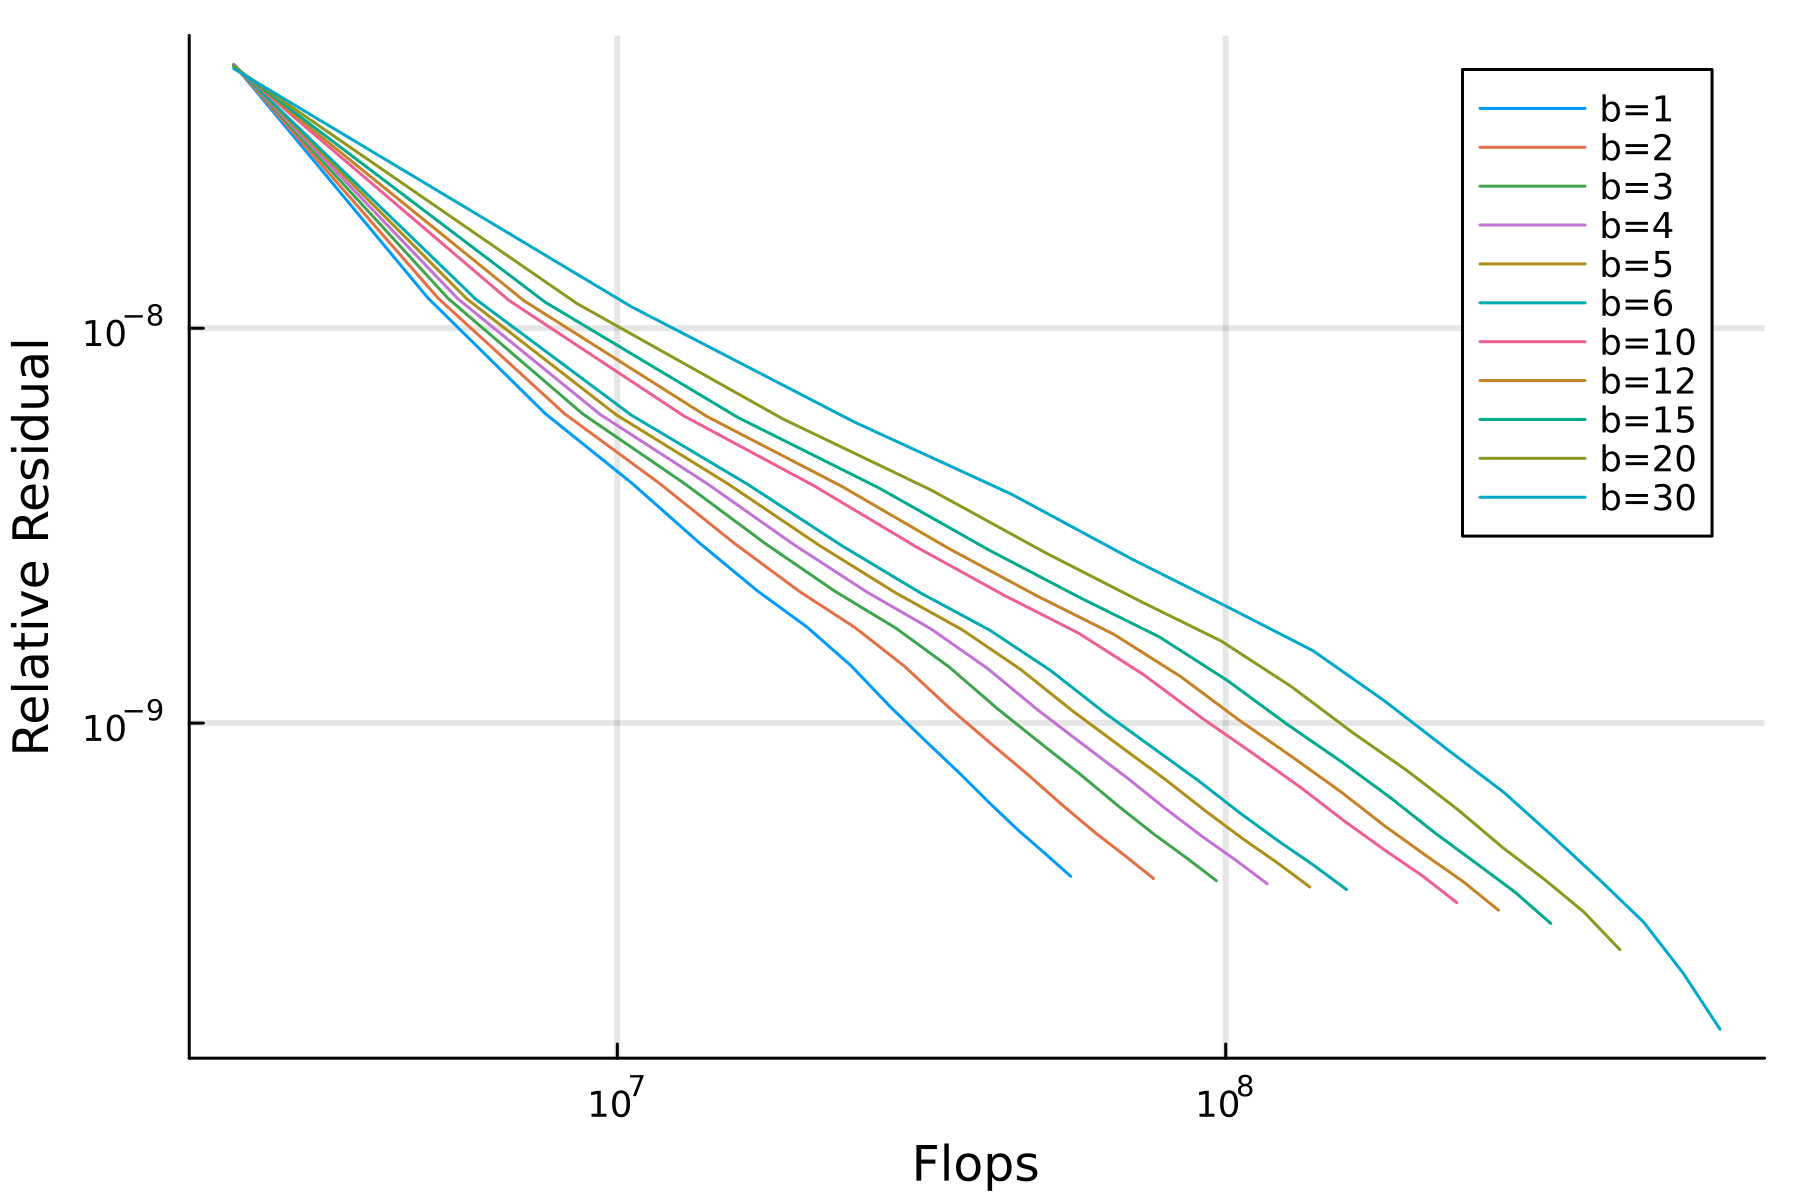

In [6]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate; cost_function=F_hat, logscale=true)
plot!(xlabel="Flops", xscale=:log10)
plot!(dpi=300)

In [7]:
savefig("hutch_flops_convergence.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/MyProject/test/hutch_flops_convergence.png"

Which is not a very favorable comparison, unfortunately. But, there is another benefit of blocking: increased cache efficiency afforded by BLAS level 3, which should in theory allow us to compute the estimator more quickly (even if the computational complexity is higher)

## Comparison with Equal Times
Now we compare the convergence rate (as a function of block size) given equal computing times

In [16]:
ks = collect(1:1:20)
bs = divisors(s)[1:end-1]
partial_hutchinson_estimator = (b, k) -> 
                hutchinson_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided, reorthogonalization_fraction=reorth_frac)
block_estimates, block_times = compute_block_estimates(ks, bs, partial_hutchinson_estimator; profile=true);

In [20]:
# Define a cost function that just returns the computed time
function time_cost(k, b)
    k_index = findfirst(x -> x== k, ks)
    b_index = findfirst(x -> x== b, bs)
    return block_times[b_index, k_index]
end

time_cost (generic function with 1 method)

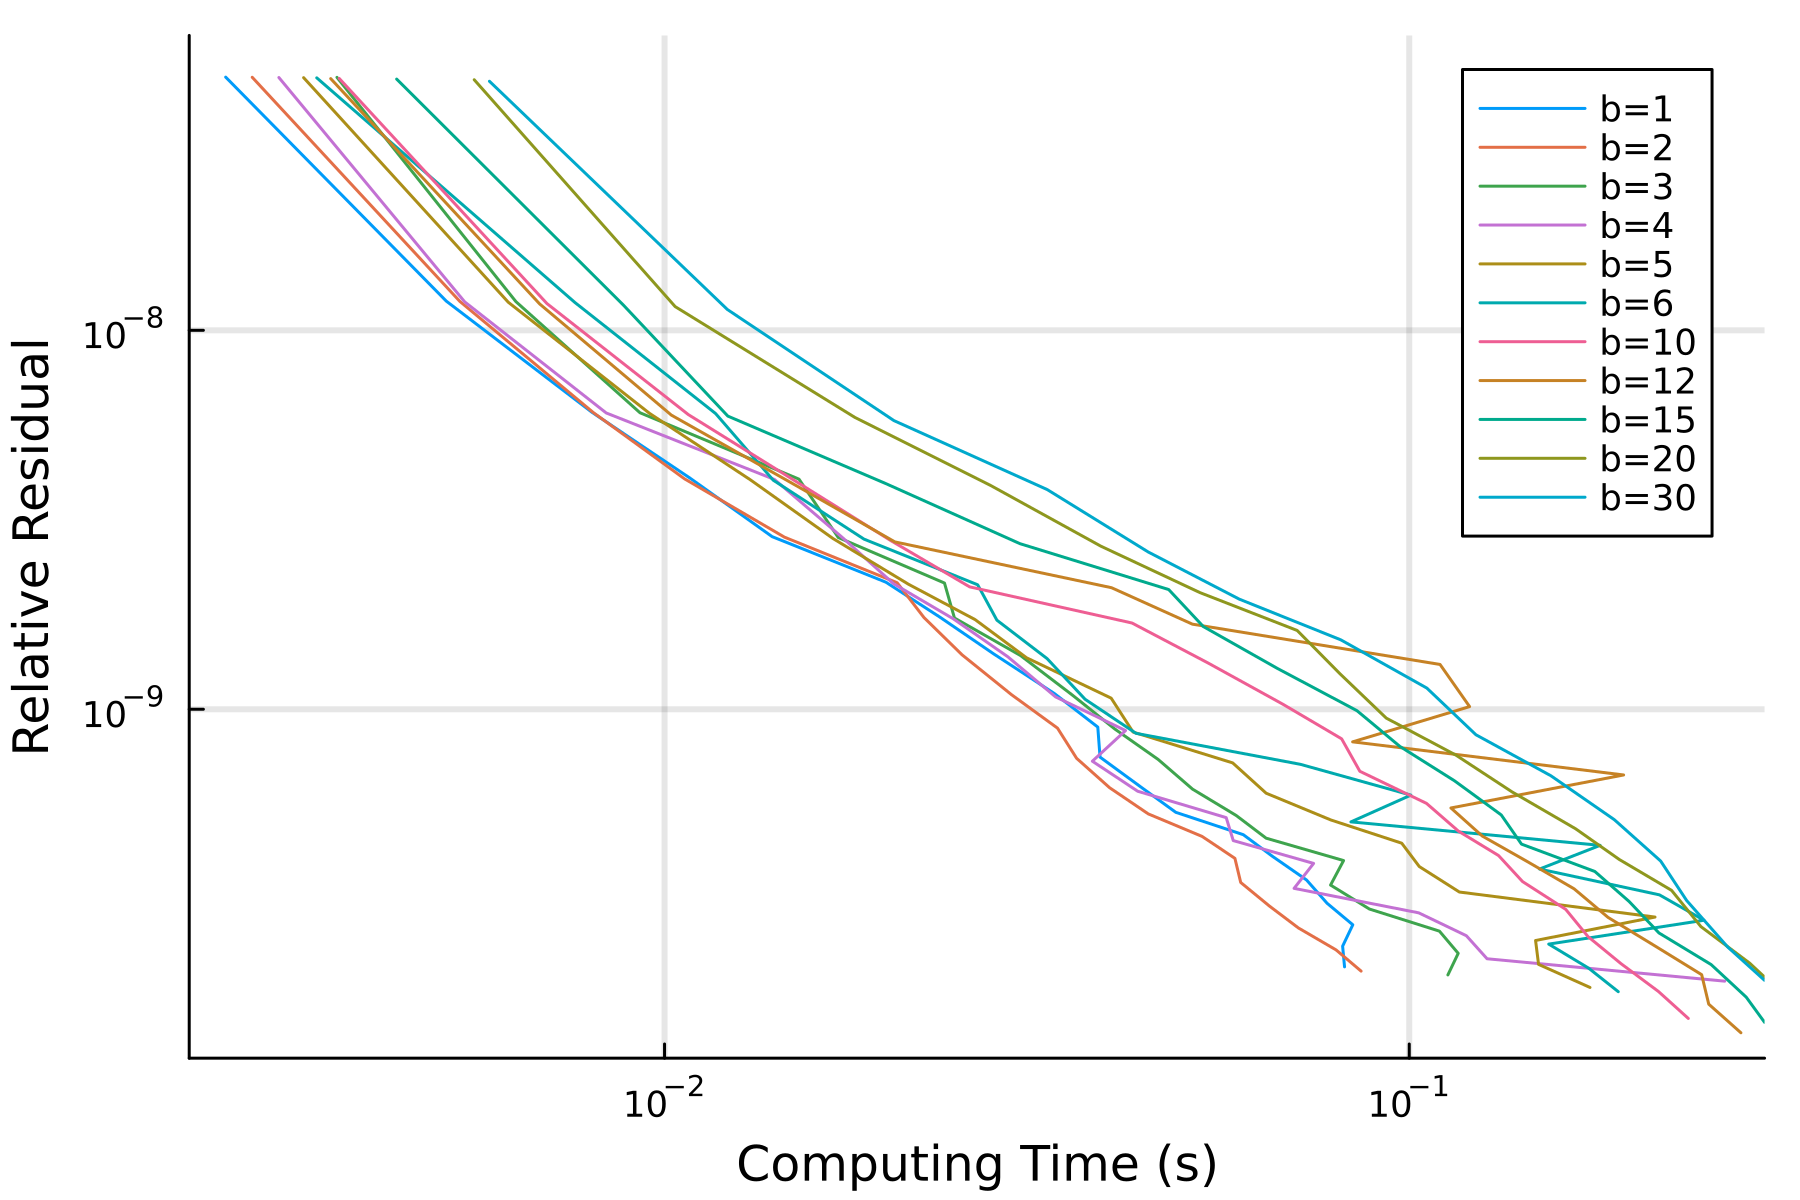

In [ ]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate; cost_function=time_cost, logscale=true)
plot!(xlabel="Computing Time (s)", xscale=:log10) # xlims=(2.3e-3, 3e-1), ylims=(1.2e-10, 0.6e-7)
plot!(dpi=300)

In [55]:
savefig("hutch_time_convergence.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/MyProject/test/hutch_time_convergence.png"

## Hutch ++ Comparisons
Now we do the same studies for the Hutch++ estimator, which we expect will have the same trends

### Flops Comparison

In [56]:
s = 60
b = 2
k_converged = 40
Ω_provided = rand([-1,1], n, s)
converged_estimate = hutch_pp_estimator(f, matvecA, n, s, b, k_converged; Ω_provided=Ω_provided, 
    reorthogonalization_fraction=1.0)

7.012841482993821e9

In [57]:
ks = collect(1:1:15)
bs = divisors(s÷2)[1:end]
partial_hutch_pp_estimator = (b, k) -> 
                    hutch_pp_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided, reorthogonalization_fraction=reorth_frac)
block_estimates = compute_block_estimates(ks, bs, partial_hutch_pp_estimator);

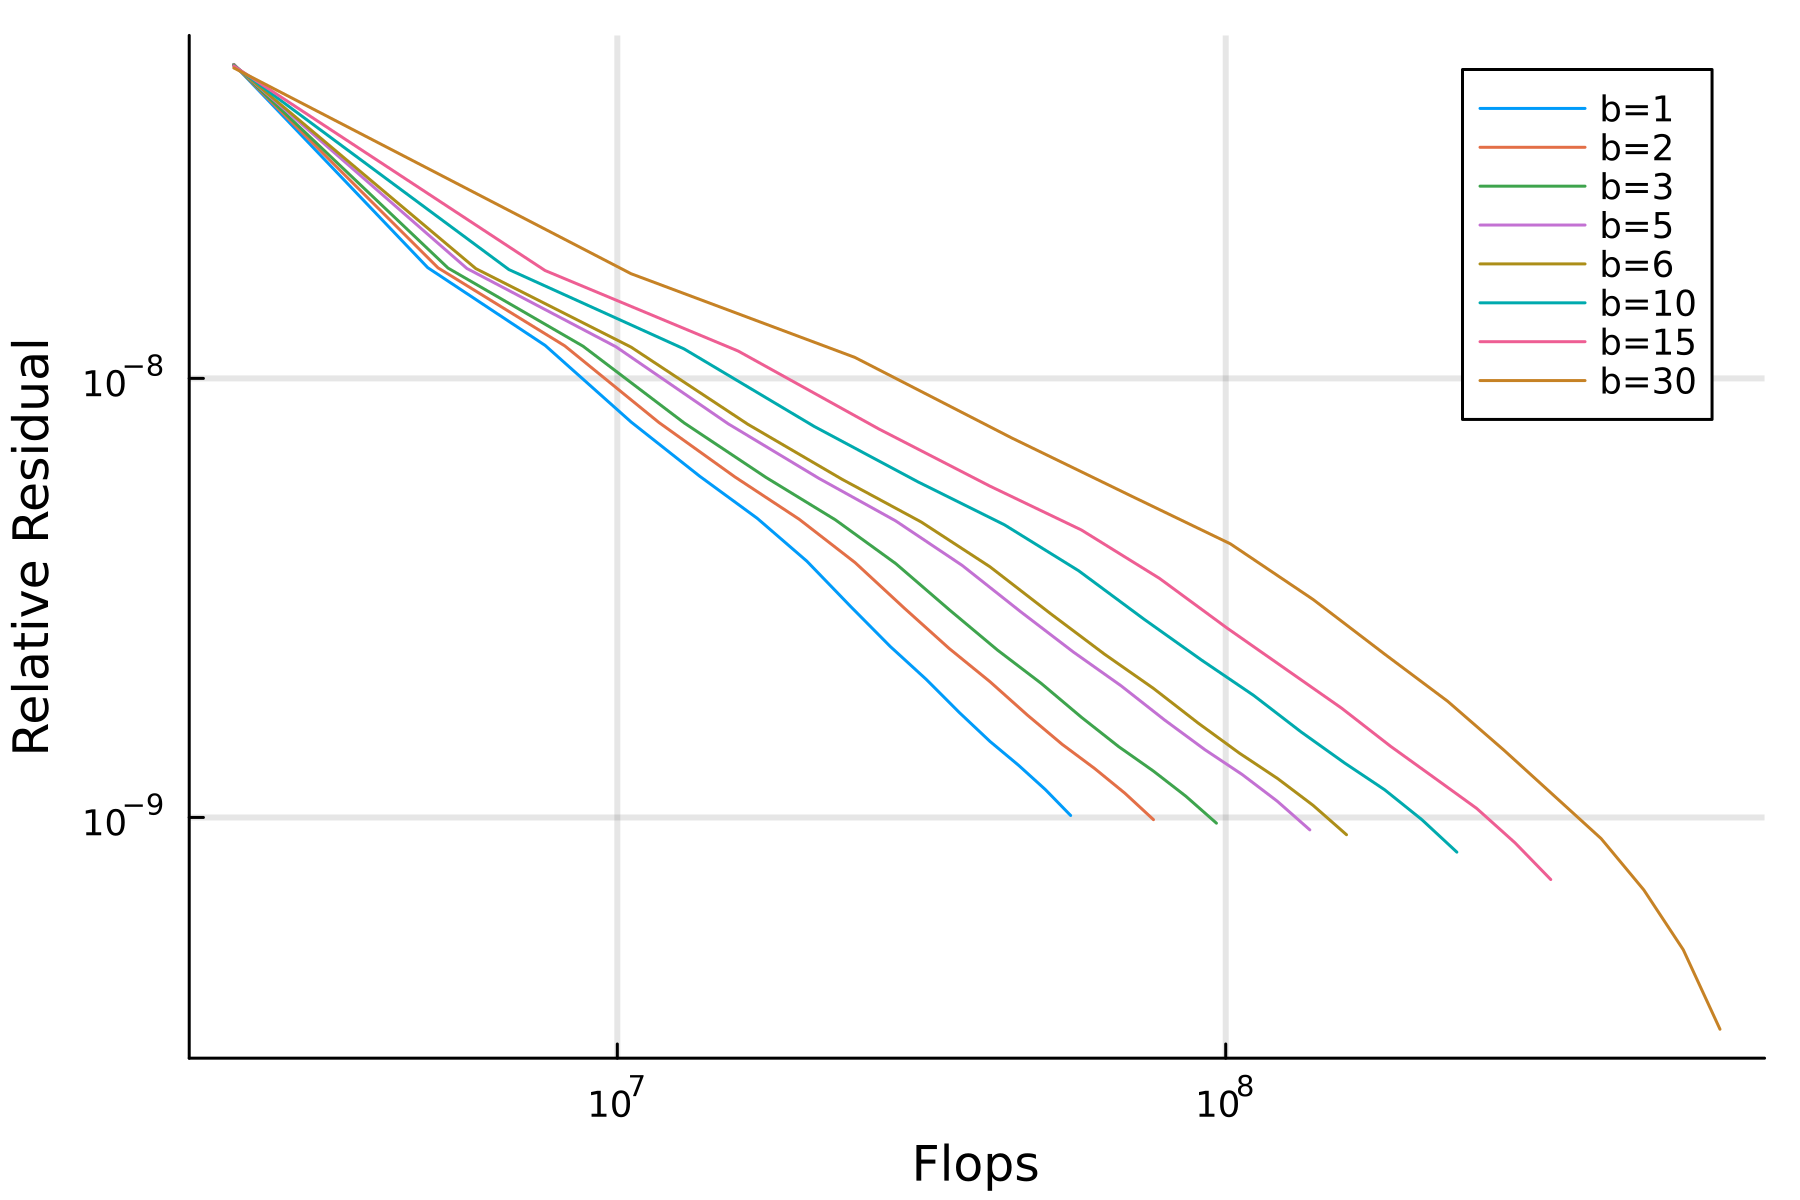

In [58]:
p = plot_block_estimates(block_estimates, ks, bs, converged_estimate; cost_function=F_hat, logscale=true)
plot!(xlabel="Flops", xscale=:log10)
plot!(dpi=300)

In [59]:
savefig("hutch_pp_flops_convergence.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/MyProject/test/hutch_pp_flops_convergence.png"

### Time Comparison

In [60]:
ks = collect(1:1:15)
bs = divisors(s÷2)[1:end]
partial_hutch_pp_estimator = (b, k) -> 
                    hutch_pp_estimator(f, matvecA, n, s, b, k; Ω_provided=Ω_provided, reorthogonalization_fraction=reorth_frac)
block_estimates, block_times = compute_block_estimates(ks, bs, partial_hutch_pp_estimator; profile=true);

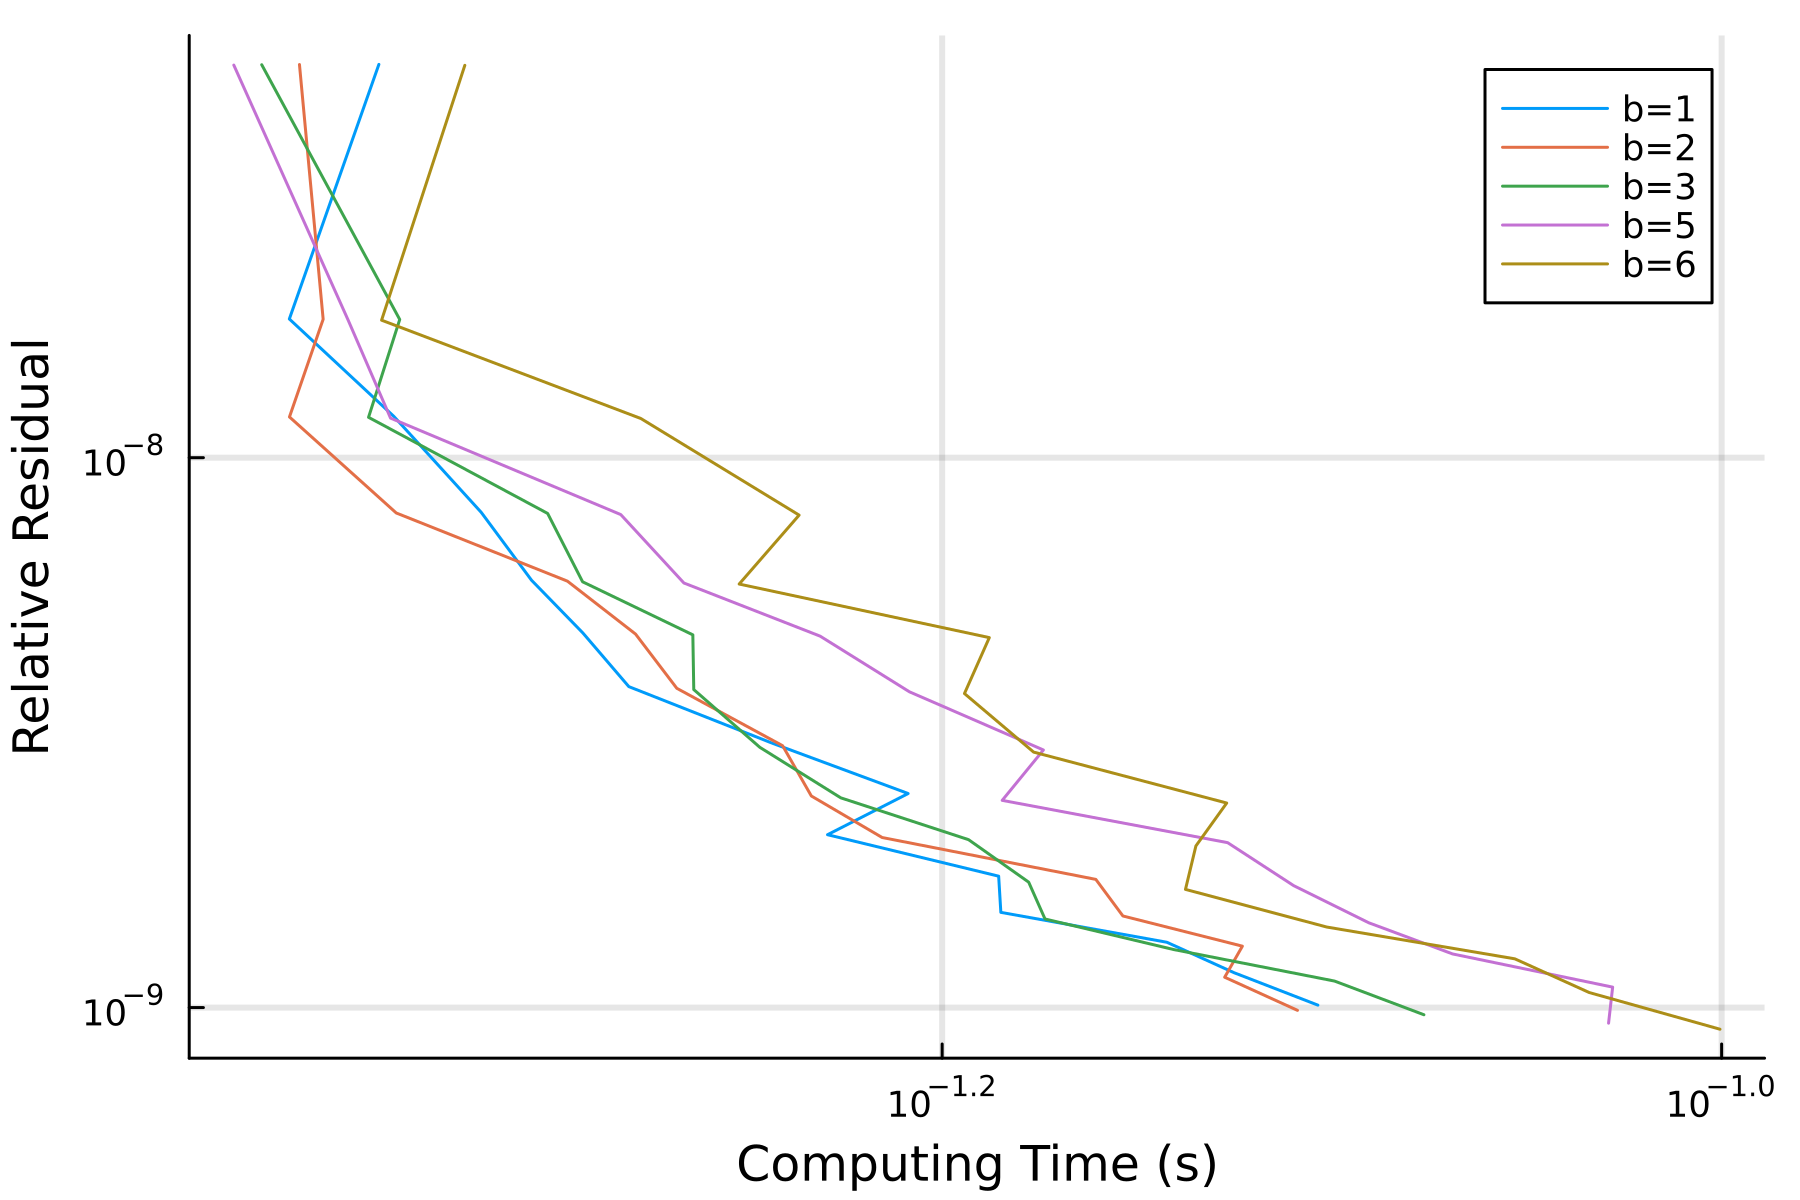

In [61]:
p = plot_block_estimates(block_estimates, ks, bs[1:5], converged_estimate; cost_function=time_cost, logscale=true)
plot!(xlabel="Computing Time (s)", xscale=:log10)
plot!(dpi=300)

In [62]:
savefig("hutch_pp_time_convergence.png")

"/home/mlouis9/shared/Educational Stuffs/Classes/Fall 2024/Iterative Methods/MyProject/test/hutch_pp_time_convergence.png"